# Intel Image Classification

The Intel Image Classification dataset is a collection of labeled images categorized into 6 types: **buildings, forest, glacier, mountain, sea, and street**. This dataset is intended for image classification tasks, providing a variety of real-world environmental categories. It can be used to train machine learning models for visual recognition tasks, helping in the development of models for image classification, especially in areas like environmental monitoring or geographical mapping.

## Required installations and libraries

Can be installed using the command `! pip install` below or by executing the installation with the `requirements.txt` file in the terminal using the command `pip install -r requirements.txt`.

In [ ]:
# ! pip install numpy
# ! pip install pandas
# ! pip install matplotlib
# ! pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from collections import Counter
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import load_model

## Auxiliary code/functions

In [2]:
def counting_iterator(dataset_iterator, dataset_name, item_type='images'):
    """
    Counts the number of items (images or batches) in a TensorFlow dataset iterator.
    Prints the result as a message without returning anything.

    Input:
        dataset_iterator: tf.data.Dataset
            A TensorFlow dataset iterator containing the data.
        dataset_name: str
            Name of the dataset (e.g., 'train', 'test', 'validation').
        item_type: str, optional
            Specifies whether we are counting individual 'images' or 'batches'. Defaults to 'images'.

    Output:
        None
    """
    total_items = sum(1 for _ in dataset_iterator)

    print(f'The {dataset_name} dataset has {total_items} {item_type}.')

In [3]:
def count_items_by_label(dataset, labels_names):
    """
    Counts the number of items per label in a dataset.

    Input:
        dataset: tf.data.Dataset
            A TensorFlow dataset iterator containing the data.
        labels_names: list
            A list of class labels corresponding to the indices in the dataset.

    Output:
        label_counting: dict
            A dictionary with the class index as keys and the number of items as values.
    """

    label_counting = Counter()

    for _, label in dataset:
        class_idx = np.argmax(label.numpy())    # converting the tensor label to a numpy array and obtaining the index with argmax
        label_counting[class_idx] += 1          # label_counting will be a dictionary with label_idx as keys and number of images as values
    
    for index, count in label_counting.items():
        print(f'{labels_names[index]}: {count} images.')
    
    return label_counting

In [4]:
def show_images(dataset, class_names, num_images=16, rows=4, cols=4):
    """
    Adapted from: https://www.tensorflow.org/tutorials/load_data/images#visualize_the_data in order to 
    display a grid of 16 images from a dataset along with their corresponding class labels in a 4x4 grid.

    Input:
        dataset: tf.data.Dataset
            A TensorFlow dataset that yields image-label pairs.
        
        class_names: list
            A list of class names corresponding to the one-hot encoded labels. The index 
            of each class name in this list corresponds to the class label.
        
        num_images : int, optional
            The number of images to display. Default is 16.

        rows : int, optional
            The number of rows in the image grid. Default is 4.

        cols : int, optional
            The number of columns in the image grid. Default is 4.

    Output:
        None
            Simply displays the images and their corresponding labels in a grid layout.

    """
    plt.figure(figsize=(10, 10))
    for i, (imagem, label) in enumerate(dataset.take(num_images)):
        if i >= num_images:
            break
        plt.subplot(rows, cols, i+1)
        plt.imshow(imagem.numpy().astype("uint8"))
        plt.axis('off')
        class_name = class_names[label.numpy().argmax()]
        plt.title(f'{class_name}')
    plt.show()

In [5]:
def plot_accuracy_f1_loss(history, epochs):
    """
    Adapted from: https://www.tensorflow.org/tutorials/images/classification to plot the
    training and validation accuracy, F1 score, and loss metrics during training.

    Input:
        history: keras.callbacks.History
            The history object returned by the model.fit() function.
        
        epochs: int
            The number of epochs used during training. This is used to determine the range for the x-axis in the plots.
    
    Output:
        None
            Display a grid of 3 plots: Training and Validation Accuracy, F1 Score and Loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    f1_score = history.history['f1_score']
    val_f1_score = history.history['val_f1_score']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(10,6))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, f1_score, label='Training F1 Score')
    plt.plot(epochs_range, val_f1_score, label='Validation F1 Score')
    plt.legend(loc='lower right')
    plt.title('F1 Score')

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.show()

In [6]:
def save_model_log(model_name, history, epochs, file_path='log.json'):
    """ 
    Save the best performance metrics of the model to a JSON log file.

    Input:
        model_name: str
            The name of the model being logged.
            
        history: keras.callbacks.History
            The history object returned by the model.fit() function, containing the training metrics.

        epochs: int
            The number of epochs used during training. This is used to track the training process.

        file_path: str, optional (default='log.json')
            The file path where the log data will be saved. If the file exists, the data will be appended.

    Output:
        None
            The function saves the best metrics to a JSON file, without returning any value.
    """ 

    best_training_loss = min(history.history['loss'])
    best_training_accuracy = max(history.history['accuracy'])
    best_training_f1_score = max(history.history['f1_score'])

    best_val_loss = min(history.history['val_loss'])
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_f1_score = max(history.history['val_f1_score'])

    log_data = {
        'model_name': model_name,
        'epochs': epochs,
        'configurations': {
            'optimizer': 'Adam',
            'loss_function': 'CategoricalCrossentropy (from_logits=True)',
            'metrics': ['Accuracy', 'F1 Score']
        },
        'best_metrics': {
            'training': {
                'loss': best_training_loss,
                'accuracy': best_training_accuracy,
                'f1_score': best_training_f1_score
            },
            'validation': {
                'loss': best_val_loss,
                'accuracy': best_val_accuracy,
                'f1_score': best_val_f1_score
            }
        }
    }

    try:
        with open(file_path, 'a') as f:
            json.dump(log_data, f, indent=4)
            f.write('\n')
        
    except Exception as e:
        print(f'An error occurred: {e}')
        with open(file_path, 'w') as f:
            json.dump(log_data, f, indent=4)

## Load the dataset

I have downloaded the dataset from the Kaggle repository available at the following link: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data.

According to the dataset description, it contains approximately **25 000 images of size 150x150, distributed across 6 categories**: {0: Buildings, 1: Forest, 2: Glacier, 3: Mountain, 4: Sea, 5: Street}.

The data is already split into 3 subsets: training (~14 000 images), testing (~3 000 images), and prediction (~7 000 images).

Since the purpose of this project is to rapidly iterate through the training process, I will only upload one split, specifically the training set, which will be further divided later on.

In [7]:
dataset_directory = '../Project_DeepLearning/input/seg_train'

To properly load the dataset, I referred to the documentation available at https://keras.io/api/data_loading/image/#image-data-loading.

This will return a `tf.data.Dataset` object, where images are represented as tensors of shape `(batch_size, image_height, image_width, num_channels)` and labels are tensors of shape `(num_labels,)`, corresponding to one-hot encoded vectors.

In [8]:
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

dataset = keras.utils.image_dataset_from_directory(
    dataset_directory,
    labels='inferred',                 # Labels will be named as the folders' names
    label_mode='categorical',          # To get the labels as one-hot encoded vectors
    batch_size=None,
    image_size=(150,150),              # Image Size as per the documentation of the dataset
    shuffle=True,
    seed=42
)

Found 14034 files belonging to 6 classes.


In [9]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None))>

In [10]:
for image, label in dataset:
    print(f'Image shape: {image.shape}')
    print(f'Label shape: {label.shape}')
    print(label)
    break

Image shape: (150, 150, 3)
Label shape: (6,)
tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float32)


The shape of the image is (150, 150, 3), which means the images are in color with **3 RGB channels**.

In [11]:
dataset.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## Visualize the data

In [12]:
labels_names = dataset.class_names

print(labels_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


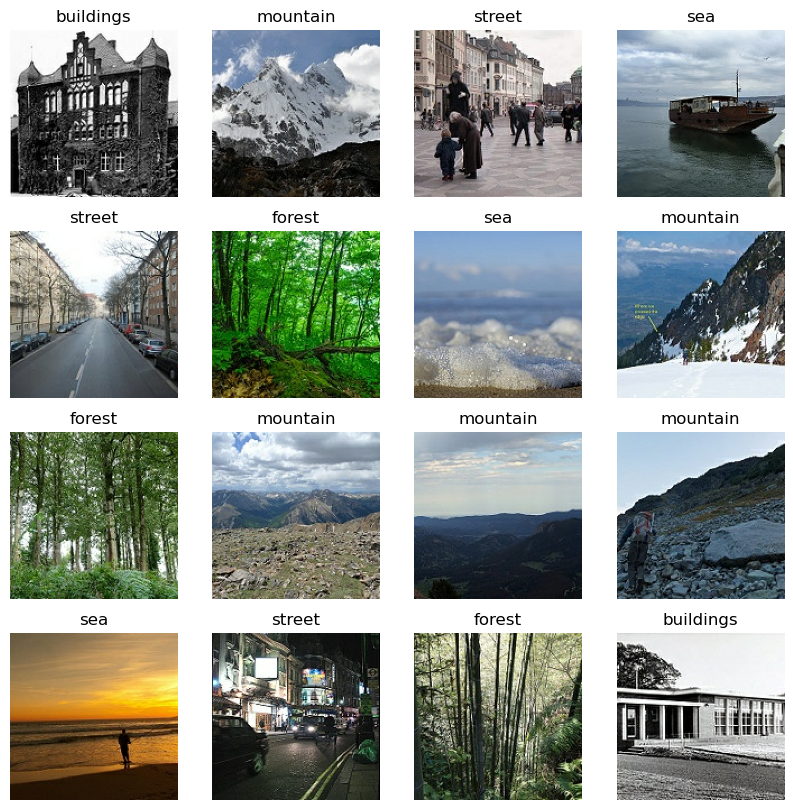

In [13]:
show_images(dataset, labels_names)

## Explore the dataset

Upon loading the dataset, we observe that it contains 14 034 images across 6 classes. However, will verify whether the classes are balanced or not.

In [14]:
n_images_per_label = count_items_by_label(dataset, labels_names)

street: 2382 images.
mountain: 2512 images.
forest: 2271 images.
sea: 2274 images.
buildings: 2191 images.
glacier: 2404 images.


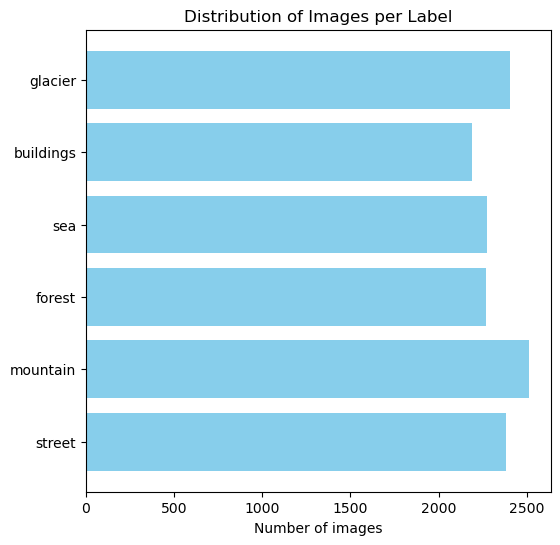

In [15]:
# Visualize graphically the distribution of images per class

classes = [labels_names[i] for i in n_images_per_label.keys()]
counts = [n_images_per_label[i] for i in n_images_per_label.keys()]

plt.figure(figsize=(6, 6))
plt.barh(classes, counts, color='skyblue')
plt.xlabel('Number of images')
plt.title('Distribution of Images per Label')
plt.show()

## Transform the dataset

### Train, test, validation splits

Since the purpose of this project is to build a Neural Network from scratch and test different architectures, I will split the dataset into training, validation, and testing sets with fewer examples: 3 000 for training, 1 500 for validation, and 600 for testing.

For this, I have used the `split_dataset` function as referenced in the following link: https://keras.io/api/utils/python_utils/#splitdataset-function.

In [16]:
from tensorflow.keras.utils import split_dataset

train_size = 3000
val_size = 1500
test_size = 600

# Dividing the dataset into the training dataset with 3000 images, and the rest

train_ds, rest = tf.keras.utils.split_dataset(
    dataset,
    left_size=train_size,
    seed=42
)

# Now with the rest dataset from above, I will divide into validation and test datasets

val_ds, test_ds = tf.keras.utils.split_dataset(
    rest,
    left_size=val_size,
    right_size=test_size,
    seed=42
)

In [17]:
counting_iterator(train_ds, 'train'),
counting_iterator(val_ds, 'test'),
counting_iterator(test_ds, 'validation')

The train dataset has 3000 images.
The test dataset has 1500 images.
The validation dataset has 600 images.


sea: 520 images.
mountain: 555 images.
glacier: 490 images.
buildings: 467 images.
street: 464 images.
forest: 504 images.


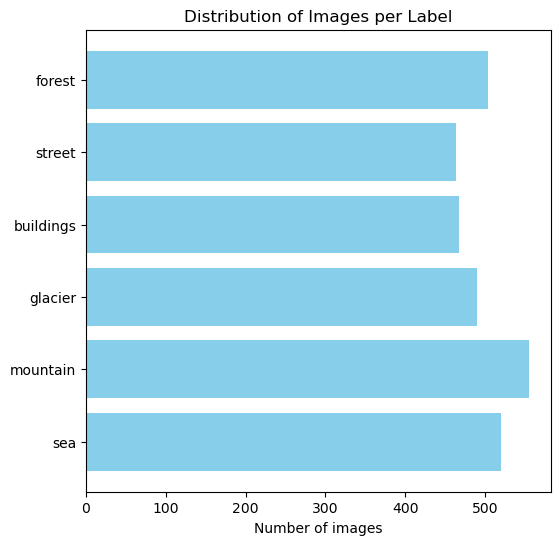

In [18]:
label_n_train = count_items_by_label(train_ds, labels_names)

# Visualize graphically the distribution of images per class

classes_train = [labels_names[i] for i in label_n_train.keys()]
counts_train = [label_n_train[i] for i in label_n_train.keys()]

plt.figure(figsize=(6, 6))
plt.barh(classes_train, counts_train, color='skyblue')
plt.xlabel('Number of images')
plt.title('Distribution of Images per Label')
plt.show()

In [19]:
label_n_val = count_items_by_label(val_ds, labels_names)

mountain: 260 images.
sea: 233 images.
street: 267 images.
glacier: 273 images.
forest: 247 images.
buildings: 220 images.


In [20]:
label_n_test = count_items_by_label(test_ds, labels_names)

glacier: 101 images.
forest: 83 images.
street: 95 images.
mountain: 120 images.
sea: 109 images.
buildings: 92 images.


### Normalize Data

In [21]:
def normalize_image(image, label):
    return tf.cast(image, tf.float32)/255.0, label

In [22]:
normalize_train_ds = train_ds.map(normalize_image)
normalize_val_ds = val_ds.map(normalize_image)
normalize_test_ds = test_ds.map(normalize_image)

In [23]:
# Checking if values were normalized: 

for image, label in normalize_train_ds.take(1):
    print(image.shape)
    print("Min:", tf.reduce_min(image).numpy())
    print("Max:", tf.reduce_max(image).numpy())

(150, 150, 3)
Min: 0.0
Max: 1.0


### Define Batch Size

In [24]:
train_dataset = normalize_train_ds.batch(256)
test_dataset = normalize_test_ds.batch(256)
val_dataset = normalize_val_ds.batch(256)

In [25]:
counting_iterator(train_dataset, 'train', 'batches')
counting_iterator(test_dataset, 'test', 'batches')
counting_iterator(val_dataset, 'validation','batches')

The train dataset has 12 batches.
The test dataset has 3 batches.
The validation dataset has 6 batches.


The datasets have now been preprocessed and transformed, and are ready for the training and validation process.

# Modelling

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Metrics

I chose **Accuracy** and **F1 Score** as evaluation metrics. 

Accuracy provides a general sense of the model's performance, but it can be misleading in imbalanced datasets. Although the Intel Image Classification dataset is not imbalanced, I’ll use F1 Score to maintain robustness and prevent any potential issues in this regard. Additionally, the F1 Score harmonizes both precision and recall, ensuring a more comprehensive assessment of the model, rather than relying solely on accuracy.

## Baseline model

I will start by building a model using only Dense layers, to establish a baseline for comparing the performance of Dense-based models with Convolutional-based ones.

In [27]:
num_classes = len(labels_names)


baseline_model = Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes)
])

In [28]:
baseline_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score')
    ]
)

In [29]:
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,650,662 (33.00 MB)

 Trainable params: 8,650,662 (33.00 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
epochs=50
history = baseline_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.1625 - f1_score: 0.1065 - loss: 11.9336 - val_accuracy: 0.2660 - val_f1_score: 0.1374 - val_loss: 3.8544
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2159 - f1_score: 0.1556 - loss: 3.2858 - val_accuracy: 0.1520 - val_f1_score: 0.0554 - val_loss: 2.3844
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.2065 - f1_score: 0.1831 - loss: 2.1423 - val_accuracy: 0.3233 - val_f1_score: 0.2528 - val_loss: 1.6568
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3144 - f1_score: 0.3053 - loss: 1.6614 - val_accuracy: 0.4620 - val_f1_score: 0.4160 - val_loss: 1.4634
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3954 - f1_score: 0.3755 - loss: 1.5075 - val_accuracy: 0.4360 - val_f1_score: 0.3942 - val_loss: 1.4384
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4219 - f1_score: 0.4012 - loss: 1.4800 - val_accuracy: 0.4633 - val_f1_score: 0.4316 - va

In [31]:
save_model_log('baseline_model', history, epochs)

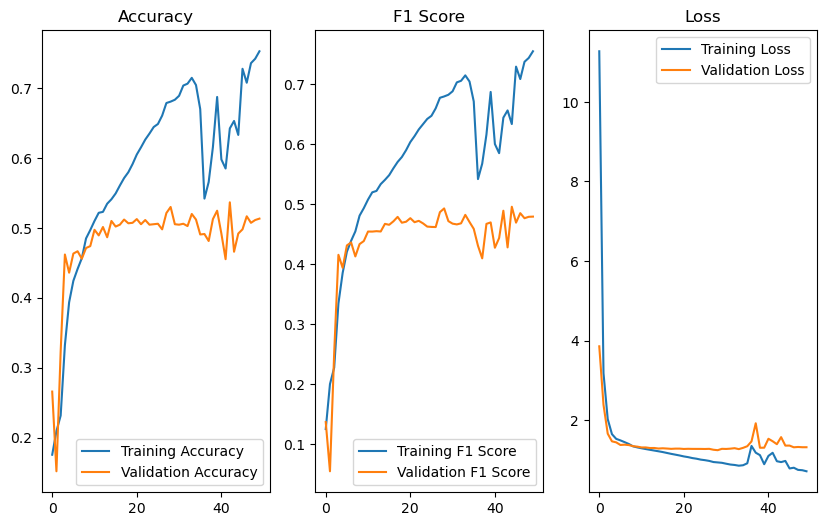

In [32]:
plot_accuracy_f1_loss(history, epochs)

It is now evident why Dense layers are not ideal for extracting meaningful features from images. Not only are the metrics generally underwhelming, but the validation metrics also quickly stagnated around 50%, indicating poor performance.

## Models with Convolutional Layers

I will now build a neural network using Convolutional layers, which are known to be more effective for image classification. Therefore, I expect it to outperform the baseline model.

I’ll start with a shallow architecture and gradually increase its depth, exploring techniques such as Padding, Max Pooling and regularization techniques along the way.

In [34]:
num_classes = len(labels_names)

cnn_base = Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes)
])

In [35]:
cnn_base.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score')
    ]
)

In [36]:
cnn_base.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 682112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │    21,827,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,832,902 (83.29 MB)

 Trainable params: 21,832,902 (83.29 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
epochs = 20

history_cnn_base = cnn_base.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 690ms/step - accuracy: 0.2096 - f1_score: 0.1778 - loss: 10.6220 - val_accuracy: 0.3613 - val_f1_score: 0.2513 - val_loss: 1.6546
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 635ms/step - accuracy: 0.3789 - f1_score: 0.2606 - loss: 1.5414 - val_accuracy: 0.3553 - val_f1_score: 0.2663 - val_loss: 1.3623
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 639ms/step - accuracy: 0.5026 - f1_score: 0.4726 - loss: 1.1855 - val_accuracy: 0.5680 - val_f1_score: 0.5217 - val_loss: 1.1002
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 663ms/step - accuracy: 0.6313 - f1_score: 0.6072 - loss: 0.9301 - val_accuracy: 0.5820 - val_f1_score: 0.5558 - val_loss: 1.0787
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 648ms/step - accuracy: 0.7292 - f1_score: 0.7263 - loss: 0.7023 - val_accuracy: 0.6300 - val_f1_score: 0.5997 - val_loss: 1.0358
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 644ms/step - accuracy: 0.8396 - f1_score: 0.8414 - loss: 0.5056 - val_accuracy: 0.6493 - val_f1_score: 0.62

In [38]:
save_model_log('cnn_base', history_cnn_base, epochs)

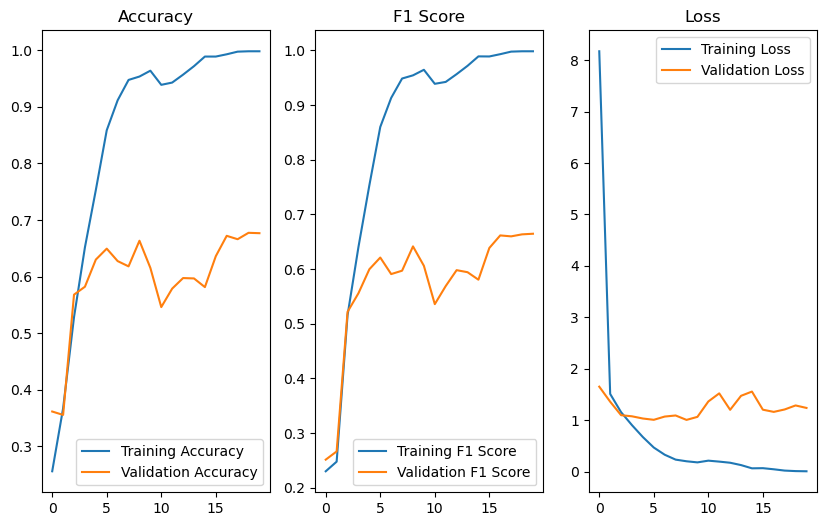

In [39]:
plot_accuracy_f1_loss(history_cnn_base, epochs)

In [40]:
print(f'The best Accuracy achieved in training with cnn_base was {round(max(history_cnn_base.history['accuracy']), 4)}.')
print(f'The best F1 Score achieved in training with the cnn_base was {round(max(history_cnn_base.history['f1_score']), 4)}.')

The best Accuracy achieved in training with cnn_base was 0.9983.
The best F1 Score achieved in training with the cnn_base was 0.9984.


The metrics from the `cnn_base` suggest that the training dataset has been memorized, as we observe nearly the maximum levels of accuracy and F1 score on the training set, which do not translate to the validation set, indicating its inefficiency in generalizing.

One potential cause of this overfitting could be the number of parameters, as the model contains around 22 million parameters according to the `cnn_base.summary()` function. 

Considering the size of the training dataset, this may be excessive. Therefore, I will now build a model incorporating the concept of **Max Pooling**, as well as **Padding**, while also increasing the depth of the architecture.

In [41]:
num_classes = len(labels_names)

cnn_v2 = Sequential([
    layers.Input(shape=(150,150,3)),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes)
])

In [42]:
cnn_v2.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score')
    ]
)

In [43]:
cnn_v2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,327,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,353,030 (5.16 MB)

 Trainable params: 1,353,030 (5.16 MB)

 Non-trainable params: 0 (0.00 B)

Using the `cnn_v2.summary()` function, we can clearly see the difference in the number of parameters when applying Max Pooling versus not. The model went from 22 million parameters down to just 1.3 million, while increasing its depth.

In [44]:
epochs = 20

history_cnn_v2 = cnn_v2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.2053 - f1_score: 0.1505 - loss: 1.8989 - val_accuracy: 0.2813 - val_f1_score: 0.2260 - val_loss: 1.5660
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - accuracy: 0.3737 - f1_score: 0.3351 - loss: 1.4589 - val_accuracy: 0.5400 - val_f1_score: 0.4904 - val_loss: 1.2307
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - accuracy: 0.5233 - f1_score: 0.5065 - loss: 1.1891 - val_accuracy: 0.5507 - val_f1_score: 0.5104 - val_loss: 1.1289
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.5816 - f1_score: 0.5723 - loss: 1.0596 - val_accuracy: 0.5860 - val_f1_score: 0.5699 - val_loss: 1.0438
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.6375 - f1_score: 0.6365 - loss: 0.9608 - val_accuracy: 0.6220 - val_f1_score: 0.6116 - val_loss: 0.9717
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - accuracy: 0.6734 - f1_score: 0.6739 - loss: 0.8760 - val_accuracy: 0.6353 - val_f1_score: 0.6240

In [45]:
save_model_log('cnn_v2', history_cnn_v2, epochs)

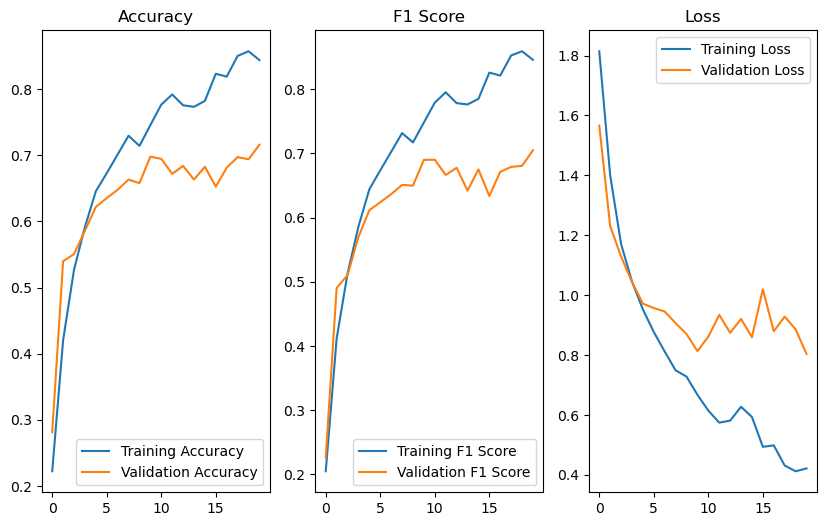

In [46]:
plot_accuracy_f1_loss(history_cnn_v2, epochs)

In [47]:
print(f'The best Accuracy achieved with cnn_v2 was {round(max(history_cnn_v2.history['accuracy']), 4)}.')
print(f'The best F1 Score achieved with the cnn_v2 was {round(max(history_cnn_v2.history['f1_score']), 4)}.')

The best Accuracy achieved with cnn_v2 was 0.8573.
The best F1 Score achieved with the cnn_v2 was 0.8592.


The divergence in metrics between the training and validation datasets suggests evidence of overfitting. However, since the validation metrics are still showing an upward trend, I will train the model for a few more epochs.

In [48]:
epochs = 10

history_cnn_v2 = cnn_v2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 0.8334 - f1_score: 0.8329 - loss: 0.4518 - val_accuracy: 0.7027 - val_f1_score: 0.6821 - val_loss: 0.8655
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - accuracy: 0.8062 - f1_score: 0.8058 - loss: 0.5319 - val_accuracy: 0.6493 - val_f1_score: 0.6315 - val_loss: 0.9739
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - accuracy: 0.7942 - f1_score: 0.7909 - loss: 0.5635 - val_accuracy: 0.7180 - val_f1_score: 0.7130 - val_loss: 0.7780
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.8631 - f1_score: 0.8644 - loss: 0.3890 - val_accuracy: 0.7147 - val_f1_score: 0.7115 - val_loss: 0.8436
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.8735 - f1_score: 0.8741 - loss: 0.3484 - val_accuracy: 0.7153 - val_f1_score: 0.7106 - val_loss: 0.8463
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - accuracy: 0.8829 - f1_score: 0.8828 - loss: 0.3229 - val_accuracy: 0.7200 - val_f1_score: 0.7114

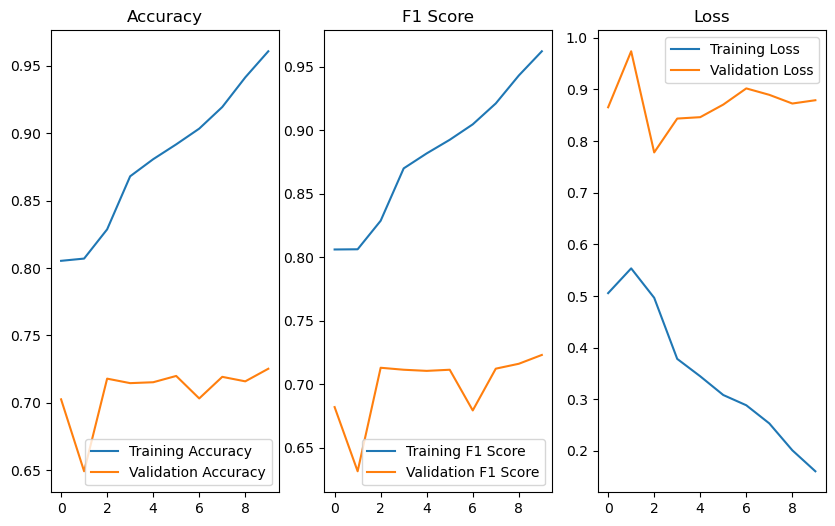

In [49]:
plot_accuracy_f1_loss(history_cnn_v2, epochs)

With both CNN models, `cnn_base` and `cnn_v2`, we can now observe the impact of using Max-Pooling. We transitioned from a 21M-parameter model that instantly overfitted the training data and performed poorly on the validation set, to a deeper model with only 1.5M parameters that showed slight improvements in the validation metrics — logs are available in the log.json file.

However, these improvements were modest (we increased accuracy from 68% to 72%), and overfitting continues to be an issue for both models.

Therefore, I will incorporate **regularization** and **dropout** techniques into the `cnn_v2` architecture to assess whether they can positively impact the model's generalization and help prevent overfitting.

In [50]:
from tensorflow.keras import regularizers

num_classes = len(labels_names)

cnn_reg = Sequential([
    layers.Input(shape=(150,150,3)),

    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),

    layers.Flatten(),                        
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(num_classes)
])

In [51]:
cnn_reg.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score')
    ]
)

In [52]:
cnn_reg.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     1,327,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,353,030 (5.16 MB)

 Trainable params: 1,353,030 (5.16 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
epochs = 25

history_cnn_reg = cnn_reg.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - accuracy: 0.2269 - f1_score: 0.2037 - loss: 2.4189 - val_accuracy: 0.4447 - val_f1_score: 0.3601 - val_loss: 1.9788
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - accuracy: 0.4117 - f1_score: 0.3996 - loss: 1.9273 - val_accuracy: 0.5553 - val_f1_score: 0.4887 - val_loss: 1.6000
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - accuracy: 0.4954 - f1_score: 0.4868 - loss: 1.6749 - val_accuracy: 0.5740 - val_f1_score: 0.5128 - val_loss: 1.4742
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - accuracy: 0.5422 - f1_score: 0.5244 - loss: 1.5307 - val_accuracy: 0.6120 - val_f1_score: 0.5877 - val_loss: 1.3583
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - accuracy: 0.5805 - f1_score: 0.5704 - loss: 1.4080 - val_accuracy: 0.6327 - val_f1_score: 0.6156 - val_loss: 1.2610
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.5972 - f1_score: 0.5942 - loss: 1.3253 - val_accuracy: 0.6247 - val_f1_score: 0.5889

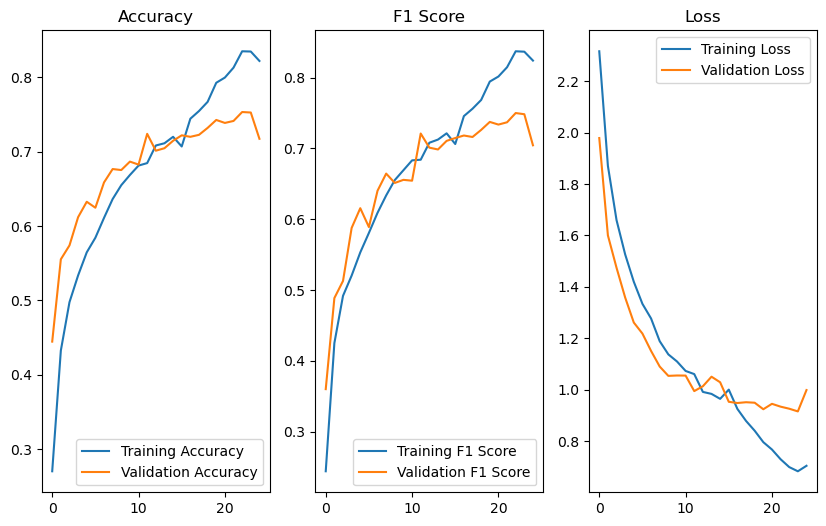

In [54]:
plot_accuracy_f1_loss(history_cnn_reg, epochs)

In [55]:
epochs = 15

history_cnn_reg = cnn_reg.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - accuracy: 0.8287 - f1_score: 0.8301 - loss: 0.7000 - val_accuracy: 0.7427 - val_f1_score: 0.7386 - val_loss: 0.9605
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 347ms/step - accuracy: 0.8439 - f1_score: 0.8452 - loss: 0.6373 - val_accuracy: 0.7387 - val_f1_score: 0.7320 - val_loss: 0.9595
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.8505 - f1_score: 0.8518 - loss: 0.6297 - val_accuracy: 0.7373 - val_f1_score: 0.7315 - val_loss: 0.9921
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.8579 - f1_score: 0.8592 - loss: 0.6168 - val_accuracy: 0.7467 - val_f1_score: 0.7408 - val_loss: 0.9486
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.8594 - f1_score: 0.8613 - loss: 0.6159 - val_accuracy: 0.7573 - val_f1_score: 0.7580 - val_loss: 0.9228
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - accuracy: 0.8769 - f1_score: 0.8783 - loss: 0.5763 - val_accuracy: 0.7480 - val_f1_score: 0.7468

In [56]:
save_model_log('cnn_reg',history_cnn_reg,epochs)

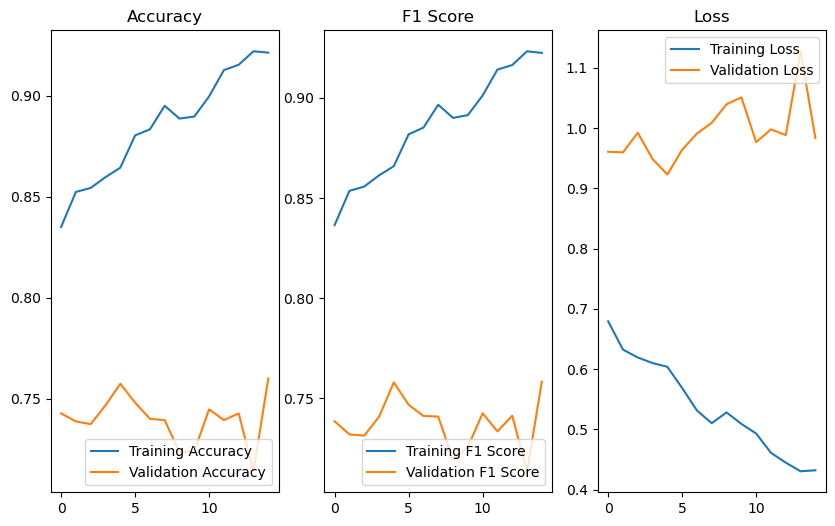

In [57]:
plot_accuracy_f1_loss(history_cnn_reg, epochs)

By incorporating regularization and dropout, we observed that the model took longer to reach the point of overfitting, and the validation metrics showed a slight improvement (increasing from 72% accuracy to 76%), as seen in the log.json file.

Nevertheless, I still aim to achieve higher metrics on the validation set. Therefore, I will apply transfer learning, leveraging pre-trained models to boost accuracy and F1 score, and further improve generalization on unseen data.

## Transfer Learning

The list of the available models can be checked at the follow link: https://keras.io/api/applications/#available-models.

Given the size of our dataset and the goal of iterating quickly through the training process, I will use the **MobileNet** architecture, as it is one of the lightest in terms of memory usage and number of parameters, which I believe is well-suited for our problem.

In [ ]:
from tensorflow.keras.applications import MobileNet

In [59]:
MobileNet = MobileNet(
    input_shape=(150,150,3),
    include_top=False,
    weights='imagenet',
)

MobileNet.summary()

C:\Users\Joao\AppData\Local\Temp\ipykernel_460\4139830945.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet = MobileNet(


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 75, 75, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 75, 75, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 75, 75, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 75, 75, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 76, 76, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 37, 37, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 37, 37, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 37, 37, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 37, 37, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

As I intend to use the pre-trained and already optimized weights, I will freeze these parameters.

In [60]:
for layer in MobileNet.layers:
    layer.trainable = False

In [84]:
# To check that there are no Treinable params now:

MobileNet.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 75, 75, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 75, 75, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 75, 75, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 75, 75, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 76, 76, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 37, 37, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 37, 37, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 37, 37, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 37, 37, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [61]:
num_classes = len(labels_names)

cnn_mobilenet = Sequential([
    MobileNet,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

In [62]:
cnn_mobilenet.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,277,894 (16.32 MB)

 Trainable params: 1,049,030 (4.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [63]:
cnn_mobilenet.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='macro', name='f1_score')
    ]
)

Since I expect this to be the best-performing model among all those created so far, I will save its structure (both architecture and weights) from the best-performing epoch — specifically, the one that achieved the highest accuracy on the validation set.

To do this, I will use the `ModelCheckpoint()` class, as described at the following link: https://keras.io/api/callbacks/model_checkpoint/ , and incorporate it into the `.fit()` method.

In [64]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='cnn_mobilenet.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False
)

In [65]:
epochs = 15

history_mobilenet = cnn_mobilenet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint]
)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 870ms/step - accuracy: 0.4191 - f1_score: 0.3931 - loss: 2.0674 - val_accuracy: 0.8133 - val_f1_score: 0.8092 - val_loss: 0.6037
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 900ms/step - accuracy: 0.7452 - f1_score: 0.7369 - loss: 0.7112 - val_accuracy: 0.8813 - val_f1_score: 0.8836 - val_loss: 0.3756
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 949ms/step - accuracy: 0.7896 - f1_score: 0.7909 - loss: 0.5599 - val_accuracy: 0.8947 - val_f1_score: 0.8958 - val_loss: 0.3277
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 790ms/step - accuracy: 0.8151 - f1_score: 0.8171 - loss: 0.4955 - val_accuracy: 0.8973 - val_f1_score: 0.8999 - val_loss: 0.2980
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 882ms/step - accuracy: 0.8288 - f1_score: 0.8294 - loss: 0.4275 - val_accuracy: 0.8940 - val_f1_score: 0.8953 - val_loss: 0.3019
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 939ms/step - accuracy: 0.8749 - f1_score: 0.8769 - loss: 0.3563 - val_accuracy: 0.9020 - val_f1_score: 0

In [66]:
save_model_log('cnn_mobilenet',history_mobilenet,epochs)

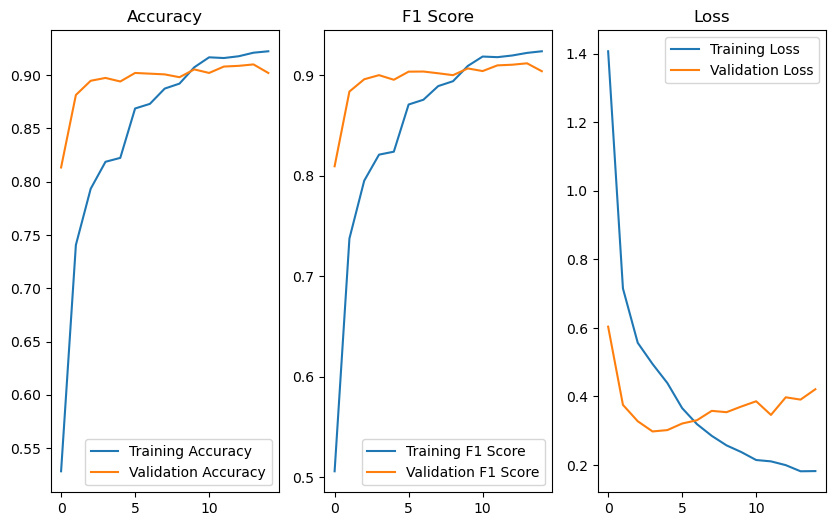

In [67]:
plot_accuracy_f1_loss(history_mobilenet, epochs)

Although the training metrics are still on an upwards trend, in the last few epochs the training and validation metrics have started to diverge, so I’ve decided not to continue training this architecture.

Even so, this clearly demonstrates the strength of using transfer learning instead of building a neural network from scratch, as the validation metrics were already better, even before any training, than those of all the previously tested models.

That said, since this is our best-performing model so far, I will use the saved iteration to evaluate its performance on the test dataset.

## Assessing the best model on the test dataset

Now that the best-performing iteration based on validation accuracy has been saved to the filepath **cnn_mobilenet.keras**, I will load this model using the `load_model()` class and evaluate its performance on the test dataset.

In [68]:
from tensorflow.keras.models import load_model

best_cnn = load_model('cnn_mobilenet.keras')

test_loss, test_accuracy, test_f1_score = best_cnn.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}%")
print(f"Test F1 Score: {test_f1_score:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - accuracy: 0.9183 - f1_score: 0.9239 - loss: 0.4003
Test Loss: 0.4086
Test Accuracy: 0.9167%
Test F1 Score: 0.9214


Since the training methodology has been validated and the model has achieved strong performance across the training, validation, and test datasets, I will now proceed to retrain this architecture using the full dataset in order to maximize the data available for final model training.

# Final Training

We still have the entire dataset stored in the **dataset** variable, which has already been shuffled. However, I will need to normalize the data, split it into batches, and apply `prefetch(tf.data.AUTOTUNE)`: This is a best practice in data pipelines, especially when training with large datasets, as it helps optimize performance by overlapping data loading and model training.

In [70]:
len(dataset)

14034

In [75]:
dataset = dataset.map(normalize_image)
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [81]:
save_best = ModelCheckpoint(
    filepath='final_cnn.keras',
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False
)

In [82]:
best_cnn.fit(
    dataset,
    epochs=10,
    callbacks=[save_best]
)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.9374 - f1_score: 0.9394 - loss: 0.1650
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - accuracy: 0.9454 - f1_score: 0.9472 - loss: 0.1332
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - accuracy: 0.9414 - f1_score: 0.9433 - loss: 0.1450
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 44s 99ms/step - accuracy: 0.9443 - f1_score: 0.9459 - loss: 0.1397
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - accuracy: 0.9451 - f1_score: 0.9468 - loss: 0.1431
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 44s 99ms/step - accuracy: 0.9427 - f1_score: 0.9446 - loss: 0.1393
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - accuracy: 0.9447 - f1_score: 0.9462 - loss: 0.1454
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - accuracy: 0.9490 - f1_score: 0.9505 - loss: 0.1279
Epoch 9/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.9466 - f1_score: 0.9482 - loss: 0.1351
Epoch 10/10
439/439 ━━━━━━━━━━━━━━

The model was trained above for a total of 30 epochs (10+10+10).

During the last 10 epochs, all metrics began to exhibit a bit of a ping-pong effect, indicating that the model was struggling to improve consistently. As a result, I decided to stop the training.

The best iteration in terms of accuracy was saved in the file `final_cnn.keras`, achieving **94% accuracy**. This represents the final performance for the problem, and the model would now be ready to be evaluated on new datasets and further improved.